In [1]:
import os#
os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
#os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [2]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_precursor_path ="data/output/Prescursor_data/precursor_data_200324.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_frag_all_2024_05_10_12_55_00//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [3]:
from src.dev_scripts.run_search_new import load_representation_model
config_dir_list_new = [f"data/representation_learning/splitrand-nummol20000"]
config_dir = config_dir_list_new[0]
from stk_search.Search_algorithm import BayesianOptimisation_ErrPred
importlib.reload(BayesianOptimisation_ErrPred)
BO = BayesianOptimisation_ErrPred.BayesianOptimisation_ErrPred(
            which_acquisition='UCB_GNN', lim_counter=5
        )
BO.verbose = True
# BO.normalise_input = False
BO.device = "cpu"  # "cuda:0" if torch.cuda.is_available() else "cpu"
BO.Representation, pymodel = load_representation_model(config_dir)
BO.pred_model = pymodel.graph_pred_linear

config loaded from data/representation_learning/splitrand-nummol20000
Model loaded:  SchNet


In [4]:

df_Benchmark = pd.read_csv(df_total_path_bench)
X_rpr = BO.Representation.generate_repr(df_Benchmark[[f'InChIKey_{i}' for i in range(6)]].loc[0:100,:])
fitness_acquired = df_Benchmark['target'].loc[0:100]
y_explored_BO =torch.tensor(fitness_acquired, dtype=torch.float64)
y_pred_model = BO.pred_model(X_rpr.float())
y_Err_BO_norm = y_explored_BO - y_pred_model.squeeze().detach().double()
y_Err_BO_norm = (y_Err_BO_norm - y_Err_BO_norm.mean(axis=0)) / (
            y_Err_BO_norm.std(axis=0)
        )

BO.target_normmean = y_Err_BO_norm.mean(axis=0)
BO.target_normstd = y_Err_BO_norm.std(axis=0)
y_Err_BO_norm = y_Err_BO_norm.reshape(-1, 1)
        # train model
BO.train_model(X_rpr.double(), y_Err_BO_norm)

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/101 [00:00<?, ?it/s]

c:\cond\envs\stk_search2\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Pandas Apply:   0%|          | 0/1401 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1400 [00:00<?, ?it/s]

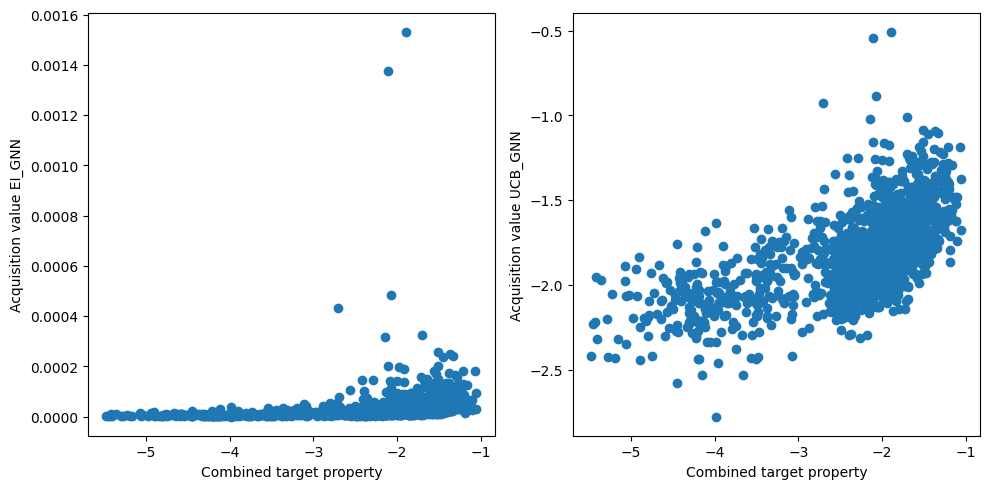

In [5]:
X_rpr = BO.Representation.generate_repr(df_Benchmark[[f'InChIKey_{i}' for i in range(6)]].loc[100:1500,:])
fitness_acquired = df_Benchmark['target'].loc[100:1500]
best_f = torch.max((y_explored_BO)-y_explored_BO.mean()/y_explored_BO.std())#-y_explored_BO.mean()
BO.which_acquisition = 'UCB_GNN'
acquisition_values_UCB = BO.get_acquisition_values(best_f,X_rpr)
BO.which_acquisition = 'EI_GNN'
acquisition_values_EI = BO.get_acquisition_values(best_f,X_rpr)
%matplotlib inline
import matplotlib.pyplot as plt
fig,axis = plt.subplots(1,2,figsize=(10,5))    
cmap = axis[0].scatter(fitness_acquired,acquisition_values_EI, label='EI_GNN')
cmap = axis[1].scatter(fitness_acquired,acquisition_values_UCB, label='UCB_GNN')
axis[0].set_ylabel('Acquisition value EI_GNN')
axis[1].set_ylabel('Acquisition value UCB_GNN')
axis[0].set_xlabel('Combined target property')
axis[1].set_xlabel('Combined target property')

#plt.colorbar(cmap)
fig.tight_layout()
